# Portfolio Project: Safety Option

**Names:** Deniz Makul, Richard Sha, Mitchel Shen

**Due:** 11/25/2022 at 11:59pm ET on Dropbox

**What to submit:** your .ipynb (python code in jupyter notebooks) file as well as a pdf with all the output from your code.  




In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from threading import Thread
import time

In [2]:
#Getting tickers from csv file
csv_tickers = pd.read_csv('Tickers_Example.csv', header = None)

In [3]:
# Returns a list of of months that have less than 20 trading days

#Setting start date and end date for volume filtering, uses 11-01 to get October as the last month
volume_start_date = '2022-01-01'
volume_end_date = '2022-11-01'

#Function to remove a month from a dataframe for volume analysis if there are less than 20 days
def remove_month(ticker):
    hist = ticker.history(start = volume_start_date, end = volume_end_date)
    
    months_to_remove = []
    #Loops through each month and creates a dataframe for each day containing data for the stock for the month
    for i in range(1,11,1):
        if i <= 9: #appends a 0 if single digit
            i = str(0) + str(i)
        df = hist.filter(like='2022-' + str(i), axis=0)
        
        #Adds to month_to_remove array if there are less than 20 rows (signalling that there were less than 20 trading days
        #for that stock)
        if len(df.index) < 20:
            months_to_remove.append('2022-' + str(i))
    return months_to_remove

In [4]:
#list to store which stocks to remove (based on indicies)
volume_index_drop = []

#Filter function, uses threading to speed up the process
def filter_stocks(ticker, i):
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = volume_start_date, end = volume_end_date, interval = '1mo', Threads = True)
    
    #If no data exists for a particular data, then the stock has been delisted, so we remove that stock
    if stock_hist.empty:
        volume_index_drop.append(i)
        return
    
    stock_volume = stock_hist['Volume']
    stock_volume = stock_volume.dropna()
    #drops the month where there are less than 20 trading days
    stock_volume = stock_volume.drop(remove_month(stock_data))
    
    mean = (stock_volume.mean())
    
    #if the average monthly volume was less than 200000, or if the stock is not in the US market, add the index to the list to 
    #drop
    if mean<200000:
        volume_index_drop.append(i)         
    elif(stock_data.info['market'] != 'us_market'):
        volume_index_drop.append(i)
    
    #volume_index_drop

In [5]:
#Drops the tickers that are delisted or have a average monthly volume from 
# January 1st to October 31st of less that 200,000

# thread_list contains all the threads
thread_list = []

for i in range(len(csv_tickers)):
    ticker = csv_tickers[0][i]
    filter_thread = Thread(target = filter_stocks, args = (ticker,i,))
    thread_list.append(filter_thread)
    #starts the threading
    filter_thread.start()

for i in thread_list:
    i.join()


- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


In [6]:
#Drops invalid tickers based on volume_index_drop
csv_tickers.drop(index = volume_index_drop, inplace = True)
csv_tickers.reset_index(drop = True, inplace = True)
csv_tickers.head()

,0
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AIG


In [7]:
close_all = pd.DataFrame()
#Gets the current date
close_date = datetime.today().strftime('%Y-%m-%d')

#Gets the close daily close price for all valid stocks in the csv file from January to the current date
def stock_history(ticker):
    close_start = '2022-01-01'
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = close_start, end = close_date, interval = '1d')
    stock_close = stock_hist['Close']
    stock_close = stock_close.dropna()
    close_all[ticker] = stock_close

In [8]:
for i in range(0,len(csv_tickers)):
    ticker = csv_tickers[0][i]
    stock_history(ticker)
    
close_all.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,182.009995,134.029205,138.551285,406.156982,57.389999,170.404495,167.788895,207.860001,45.955307,244.139999,...,31.621540,67.475571,160.300003,18.700493,230.949112,190.600006,502.279999,246.562317,211.959869,57.270000
2022-01-04,179.699997,133.771881,135.292801,403.254517,59.000000,167.522003,173.175369,213.630005,47.756504,241.729996,...,33.156757,67.475571,162.979996,18.854919,233.159531,190.800003,490.899994,250.801544,215.722519,58.770000
2022-01-05,174.919998,134.474579,134.684937,396.152924,58.189999,164.356995,171.329987,213.070007,46.950443,239.270004,...,33.156757,67.554756,161.029999,19.274082,227.872452,186.820007,489.690002,251.557831,213.012222,58.459999
2022-01-06,172.000000,133.841156,134.665009,377.022522,59.189999,163.253998,172.899994,211.339996,47.895821,237.300003,...,33.944305,67.475571,163.160004,19.200544,230.351715,186.759995,469.649994,252.254440,215.077225,60.049999
2022-01-07,172.169998,133.494751,135.083527,369.791290,60.740002,162.554001,174.380005,215.500000,48.940712,232.600006,...,34.921265,67.940781,161.270004,19.856495,229.784164,179.440002,458.600006,253.538147,216.586258,61.000000


In [9]:
#Gets the daily percentage change of each stock
close_all_pct = close_all.pct_change() * 100
close_all_pct.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,-1.269160,-0.191991,-2.351825,-0.714617,2.805368,-1.691559,3.210269,2.775909,3.919454,-0.987140,...,4.854973,0.000000,1.671861,0.825789,0.957102,0.104930,-2.265670,1.719333,1.775171,2.619172
2022-01-05,-2.659988,0.525296,-0.449295,-1.761070,-1.372884,-1.889309,-1.065615,-0.262134,-1.687856,-1.017661,...,0.000000,0.117354,-1.196464,2.223095,-2.267580,-2.085952,-0.246484,0.301548,-1.256381,-0.527482
2022-01-06,-1.669334,-0.471035,-0.014796,-4.829045,1.718508,-0.671098,0.916365,-0.811945,2.013564,-0.823338,...,2.375226,-0.117217,1.322738,-0.381537,1.088005,-0.032123,-4.092387,0.276918,0.969429,2.719809
2022-01-07,0.098836,-0.258818,0.310785,-1.917984,2.618691,-0.428778,0.855993,1.968394,2.181592,-1.980614,...,2.878124,0.689449,-1.158372,3.416312,-0.246384,-3.919465,-2.352813,0.508894,0.701624,1.582016


In [10]:
#Gets the expected return as a percentage for each stock over the period from January 1st, 2022 to October 31st, 2022
expected_return = close_all_pct.mean()
expected_return.head()

AAPL   -0.057359
ABBV    0.087845
ABT    -0.104313
ACN    -0.121394
AIG     0.049530
dtype: float64

In [11]:
#Gets the absolute differnce of the expected return from 0
expected_return_from_0 = abs(0 - expected_return)
expected_return_from_0

#Sorts the values in expected_return_from_0 from least to greatest
expected_return_sorted = sorted(expected_return_from_0.items(), key=lambda x:x[1])

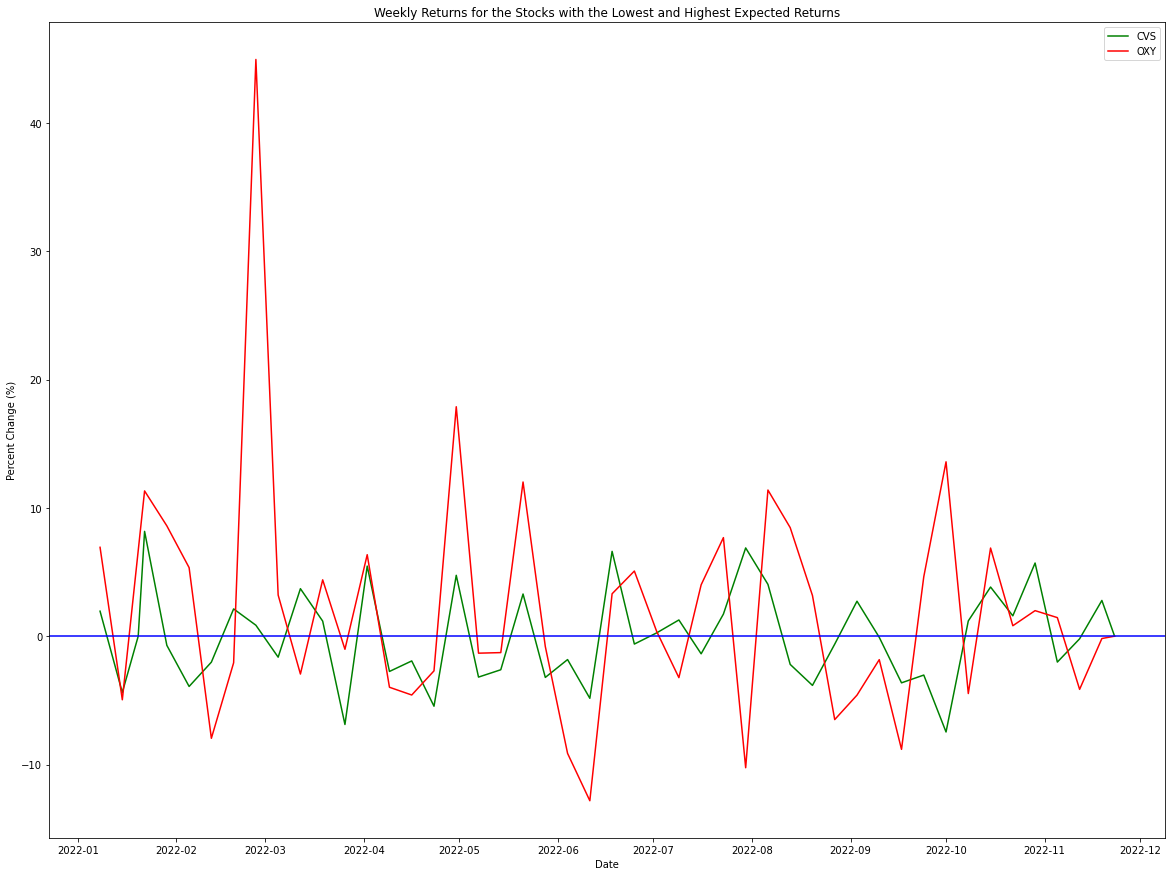

In [12]:
start_date = '2022-01-01'

lowest_expected = expected_return_sorted[0][0]
highest_expected = expected_return_sorted[-1][0]

lowest = yf.Ticker(lowest_expected)
lowest_hist = lowest.history(start=start_date, end=close_date, interval="1wk")
lowest_df = pd.DataFrame(lowest_hist.Close)
lowest_df_pct = lowest_df.pct_change()*100

highest = yf.Ticker(highest_expected)
highest_hist = highest.history(start=start_date, end=close_date, interval="1wk")
highest_df = pd.DataFrame(highest_hist.Close)
highest_df_pct = highest_df.pct_change()*100

plt.figure(figsize=(20,15))

plt.plot(lowest_df_pct.index, lowest_df_pct['Close'], color = 'g', label=lowest_expected)
plt.plot(highest_df_pct.index, highest_df_pct['Close'], color = 'r', label=highest_expected)
plt.axhline(y=0, color='b', linestyle='-')

plt.legend(loc='best')

plt.title('Weekly Returns for the Stocks with the Lowest and Highest Expected Returns')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

In [13]:
#Gets the standard deviation of each stock from January 1st to October 31st, 2022
std_lst = close_all_pct.std()
std_lst = sorted(std_lst.items(), key=lambda x:x[1])

In the code block above, we calculated the standard deviation for each ticker and appended into a list called ‘std_lst’. After that, we sorted the list so that the ticker by ascending order so that the lowest standard deviation would be at index 0, the start of the list. The reason we sorted the standard deviation by ascending order was so that the stock at first place would get the most points in our ranking system to decide the weighting of the stocks.

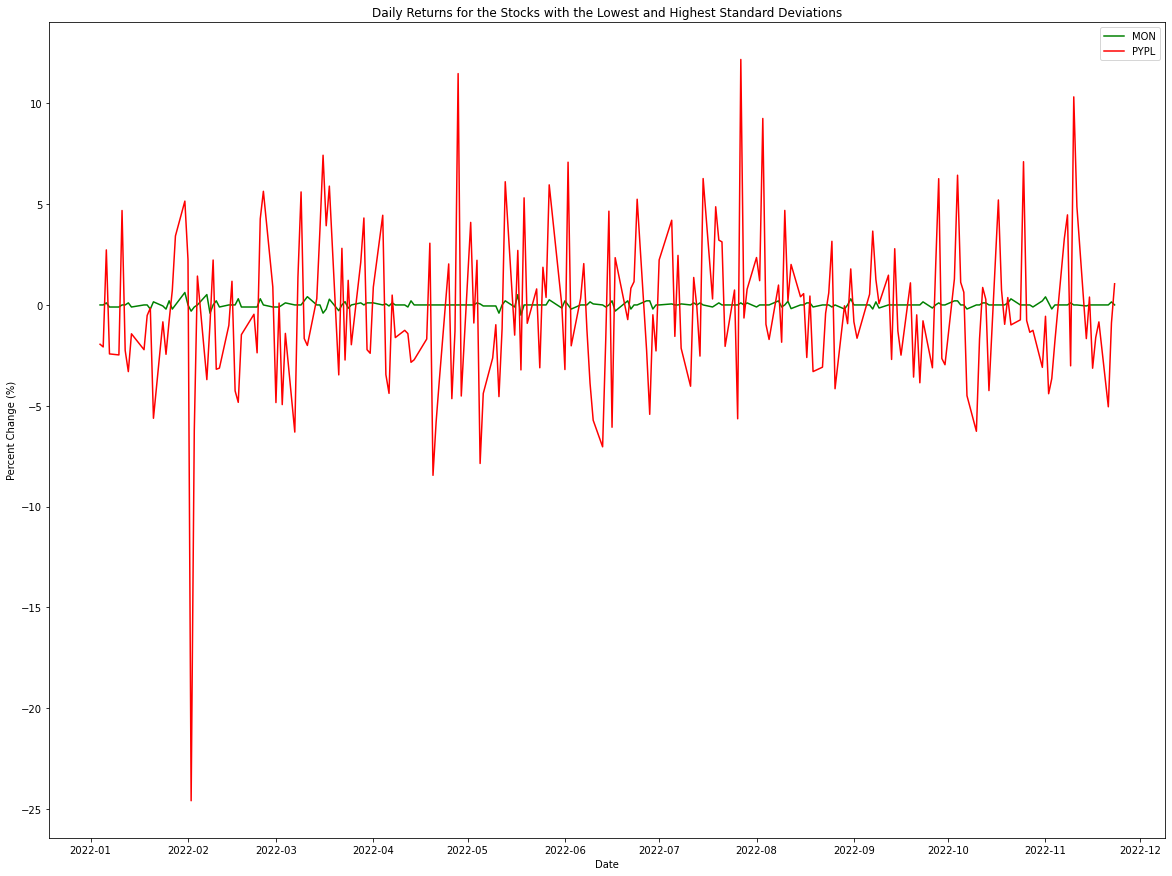

In [14]:
lowest_std = std_lst[0][0]
highest_std = std_lst[-1][0]

plt.figure(figsize=(20,15))

plt.plot(close_all_pct.index, close_all_pct[lowest_std], color = 'g', label=lowest_std)
plt.plot(close_all_pct.index, close_all_pct[highest_std], color = 'r', label=highest_std)

plt.legend(loc='best')

plt.title('Daily Returns for the Stocks with the Lowest and Highest Standard Deviations')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

In [15]:
correlation_pct_stocks = pd.DataFrame()
index = []

#Creates a DataFrame that stores correlation between any two given stocks given that the ticker is acceptable
for i in range(len(close_all_pct.columns)):
    
    #Tracks the correlation of one stock to every stock in the portfolio
    correlation_temp = {}
    
    for j in range(len(close_all_pct.columns)):
        #correlation_df: Temporary dataframe so that .corr() function can be applied to the dataframe
        correlation_df = pd.DataFrame({
            csv_tickers[0][i]: close_all_pct[csv_tickers[0][i]]
        })
        
        correlation_df[csv_tickers[0][j]] = close_all_pct[csv_tickers[0][j]]
        correlation = correlation_df.corr()[csv_tickers[0][i]][csv_tickers[0][j]]
        
        correlation_temp[csv_tickers[0][j]] = correlation
        
    correlation_pct_stocks[csv_tickers[0][i]] = list(correlation_temp.values())
    index.append(csv_tickers[0][i])

#Sets resets index values for better understanding of data
correlation_pct_stocks.index = index
correlation_pct_stocks.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,0.212476,0.617065,0.797808,0.553380,0.690033,0.653220,0.537519,0.567874,0.297580,...,0.205614,0.388616,0.592486,0.390810,0.521387,0.724884,0.482072,0.479803,0.554151,0.486013
ABBV,0.212476,1.000000,0.452144,0.326837,0.309524,0.204599,0.273148,0.108353,0.293036,0.229278,...,0.173926,0.364250,0.265727,0.280066,0.264366,0.254740,0.489960,0.247771,0.228892,0.382459
ABT,0.617065,0.452144,1.000000,0.697916,0.535801,0.505125,0.596883,0.428366,0.576459,0.323183,...,0.115791,0.451650,0.529855,0.376927,0.405675,0.541372,0.558056,0.494422,0.484853,0.560514
ACN,0.797808,0.326837,0.697916,1.000000,0.589215,0.693313,0.667075,0.506539,0.590891,0.373930,...,0.197476,0.415423,0.629489,0.376733,0.525057,0.736906,0.519115,0.551450,0.587065,0.540402
AIG,0.553380,0.309524,0.535801,0.589215,1.000000,0.456342,0.729389,0.537039,0.757203,0.246250,...,0.393880,0.293886,0.599023,0.376116,0.336363,0.490358,0.384214,0.500508,0.517223,0.726190


In [16]:
#Tracks the average correlation of a stock to the rest of the stocks
correlation_pct_mean = pd.DataFrame()
correlation_pct_mean = correlation_pct_stocks.sum()

#Subtracts 1 to account for the case in the dataframes where a stock is compared to itself for correlation
#the correlation would be 1 in this case (such as AAPL's correlation with AAPL)
correlation_pct_mean = correlation_pct_mean - 1

#One less stock (len(correlation_pct_stocks) - 1)since we don't take into account the stock itself in the 
#correlation calculations
correlation_pct_mean = correlation_pct_mean/(len(correlation_pct_stocks) - 1)

correlation_pct_mean.head()

AAPL    0.498219
ABBV    0.292076
ABT     0.472507
ACN     0.520740
AIG     0.470715
dtype: float64

In [17]:
#Gets the absolute value of the correlation from 0 (least correlation) and sorts it from least to greatest
correlation_from_0 = abs(0 - correlation_pct_mean)
correlation_from_0 = sorted(correlation_from_0.items(), key=lambda x:x[1])

In [18]:
#Creates points system
points_system = pd.DataFrame()
expected_lst = []
std_deviation_lst = []
correlation_lst = []

#Appends each stock and their rankings in the expected_lst, std_deviation and correlation_lst dataframes
for i in expected_return_sorted:
    expected_lst.append(i[0])
    
for i in std_lst:
    std_deviation_lst.append(i[0])

for i in correlation_from_0:
    correlation_lst.append(i[0])

points_system['Expected Returns'] = expected_lst
points_system['Standard Deviation'] = std_deviation_lst
points_system['Correlation'] = correlation_lst
points_system.index += 1 

#Inverses the index for the points system
points_system = points_system.set_index([points_system.index[::-1]])

points_system.head()

,Expected Returns,Standard Deviation,Correlation
55,CVS,MON,MON
54,SO,PEP,LMT
53,COST,BMY,OXY
52,TXN,KO,SLB
51,ORCL,MRK,COP


In [19]:
#Score dataframe keeps track of the points accumulated by a stock in all three categories (expected returns, standard deviation,
#correlation)
score = pd.DataFrame()
    
score['Tickers'] = expected_lst
score['Points'] = None

for i in range(len(score)):
    score['Points'][i] = (int(points_system[points_system['Expected Returns'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Standard Deviation'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Correlation'] == expected_lst[i]].index.values)) 

score = score.sort_values("Points")
score = score[::-1]
score = score.reset_index(drop=True)
score.index += 1 

score.head()

,Tickers,Points
1,MON,158
2,SO,144
3,MO,140
4,PM,134
5,CL,132


In [20]:
number_of_stocks = 25

#Creates a dataframe of the top stocks to pick (25 stocks if there are 25 or more stocks in the list, the same dataframe as 
#score if there are less)
score_dropped = score.copy()

#Accounts for the case where there are less than the number of stocks we want (25) valid tickers in the list; only when 
#there are more than 25 valid tickers would we take the first 25 tickers from the score dataframe
if (len(score) > number_of_stocks):
    score_dropped.drop(labels = range(number_of_stocks + 1, len(score) + 1), inplace = True)
score_dropped.head()

,Tickers,Points
1,MON,158
2,SO,144
3,MO,140
4,PM,134
5,CL,132


In [21]:
#Minimum weighting possible for any given stock so that there is no case where the weighting of one stock drops below the 
#minimum weighting requirement for a given stock
min_weighting = 100/(2*number_of_stocks)
base_weighting_total = min_weighting * number_of_stocks

#Gets the finalized weightings of each stock
score_dropped['Base Weighting'] = min_weighting
weighting_sum = score_dropped['Points'].sum()

score_dropped['Points-based Weighting'] = (score_dropped['Points']/weighting_sum) * (100 - base_weighting_total)
score_dropped['Total Weighting'] = score_dropped['Base Weighting'] + score_dropped['Points-based Weighting']
score_dropped.head()

,Tickers,Points,Base Weighting,Points-based Weighting,Total Weighting
1,MON,158,2.0,2.728843,4.728843
2,SO,144,2.0,2.487047,4.487047
3,MO,140,2.0,2.417962,4.417962
4,PM,134,2.0,2.314335,4.314335
5,CL,132,2.0,2.279793,4.279793


In [22]:
tickers_list = score_dropped['Tickers']
#Gets the closing price for last five days. Five days incase the program is run on the weekend and Friday is a holiday
price_last_five_days = pd.DataFrame()
Portfolio_Final = pd.DataFrame()
date_difference = 5

#initialize start_date for getting close dates from yfinance
start_date = datetime.today() - timedelta(days=date_difference)

#Getting price info for the last date (in this case 2022-11-25)
for x in tickers_list:
    stock_info = yf.Ticker(x)
    stock_hist = stock_info.history(start = start_date, end = close_date)
    
    price_last_five_days[x] = stock_hist['Close']
    
price_last_five_days = price_last_five_days.transpose()
#Gets the last column from price_last_five_days
Portfolio_Final = price_last_five_days.iloc[:,-1]
Portfolio_Final = Portfolio_Final.reset_index()
Portfolio_Final.index += 1

Portfolio_Final.head()

,index,2022-11-23 00:00:00
1,MON,10.010000
2,SO,66.360001
3,MO,45.020000
4,PM,98.110001
5,CL,76.930000


In [23]:
total_amount_to_spend = 500000
#To reset column names
column_names = ['Ticker', 'Price']
Portfolio_Final.columns = column_names

#Getting the rest of the columns for the Portfolio_Final dataframe
Portfolio_Final['Shares'] = (total_amount_to_spend*(score_dropped['Total Weighting']/100))/Portfolio_Final['Price']
Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
Portfolio_Final['Weight'] = score_dropped['Total Weighting']
Portfolio_Final


,Ticker,Price,Shares,Value,Weight
1,MON,10.010000,2362.059303,23644.214162,4.728843
2,SO,66.360001,338.083679,22435.233161,4.487047
3,MO,45.020000,490.666588,22089.810017,4.417962
4,PM,98.110001,219.872339,21571.675302,4.314335
5,CL,76.930000,278.161493,21398.963731,4.279793
6,CVS,100.059998,210.409166,21053.540587,4.210708
7,PG,146.449997,142.579921,20880.829016,4.176166
8,T,19.090000,1089.286174,20794.47323,4.158895
9,ABBV,159.389999,127.212112,20276.338515,4.055268
10,NEE,84.919998,237.752981,20189.982729,4.037997


In [24]:
#Generating Stocks_Final portfolio
Stocks_Final = pd.DataFrame()

Stocks_Final['Ticker'] = Portfolio_Final['Ticker'] 
Stocks_Final['Shares'] = Portfolio_Final['Shares']

Stocks_Final

,Ticker,Shares
1,MON,2362.059303
2,SO,338.083679
3,MO,490.666588
4,PM,219.872339
5,CL,278.161493
6,CVS,210.409166
7,PG,142.579921
8,T,1089.286174
9,ABBV,127.212112
10,NEE,237.752981


In [25]:
#Writing to csv file
Stocks_Final.to_csv("Stocks_Group_08.csv")